In [11]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm

mpl_config = pd.read_csv('mpl_config.csv').to_dict(orient='records')[0]
mpl.rcParams.update(mpl_config)

In [2]:
def compare_diff(x):
    """
    Given a 1D array x, return an array y of same length with:
        y[i] =  1 if x[i] > x[i-1]
        y[i] = -1 if x[i] < x[i-1]
        y[i] =  0 if x[i] == x[i-1]
    y[0] is set to 0 by convention.
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=int)
    diff = np.diff(x)
    
    y[1:] = np.where(diff > 0, 1, np.where(diff < 0, -1, 0))
    
    return y


### Analysis A1

In [3]:
os.chdir('/Volumes/LaCie')


files_hercule =['HERCULE_20250528_SESSION_01/headstage_0/','HERCULE_20250602_SESSION_00/headstage_0/',\
       'HERCULE_20250603_SESSION_01/headstage_0/','HERCULE_20250604_SESSION_00/headstage_0/',\
      'HERCULE_20250604_SESSION_01/headstage_0/','HERCULE_20250605_SESSION_00/headstage_0/',\
      'HERCULE_20250605_SESSION_01/headstage_0/','HERCULE_20250606_SESSION_00/headstage_0/',\
      'HERCULE_20250612_SESSION_00/headstage_0/',\
      'HERCULE_20250612_SESSION_02/headstage_0/','HERCULE_20250616_SESSION_01/headstage_0/']


for i in range(len(files_hercule)) :
    files_hercule[i]='HERCULE/' + files_hercule[i]

files_napoleon  = [f for f in os.listdir('NAPOLEON/')]
for i in range(len(files_napoleon)) :
    files_napoleon[i]='NAPOLEON/' + files_napoleon[i] + '/headstage_1/'
    
files = files_napoleon + files_hercule


n_data_s = []
f_data_s = []
for file in tqdm(files) :
    try :
        n_data = np.load(file+'data_0.005.npy')
        f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
        gc = np.load(file+'good_clusters.npy')
        
        
        f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}
    
        for item in f_data:
            for key, value in item.items():
                f_data_dict[key].append(value)

        f_data = pd.DataFrame(f_data_dict)
        f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
        n_data = n_data[gc,:].astype(float)
        #n_data=n_data.astype(float)
    
        n_data_s.append(n_data)
        f_data_s.append(f_data)
        
    except :
        print('Error when building dataframe for file :' + str(file))

os.chdir('/Users/hugot/Documents/PHD/Felicie')

  0%|          | 0/49 [00:00<?, ?it/s]

Error when building dataframe for file :NAPOLEON/NAPOLEON_20241202_SESSION_02/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241212_SESSION_02/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241213_SESSION_01/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241220_SESSION_01/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250127_SESSION_00/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250217_SESSION_00/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250217_SESSION_01/headstage_1/


In [22]:
c=0
for data in n_data_s :
    c+= np.shape(data)[0]
print(c)

755


In [4]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_s))) :
    n_data_smooth = gaussian_filter(n_data_s[i],sigma=20,axes=1)
    n_data_s[i] = n_data_smooth

  0%|          | 0/42 [00:00<?, ?it/s]

In [27]:
with open("Save/hercule_a1", "wb") as fp:   #Pickling
    pickle.dump(n_data_s[:len(files_hercule)], fp)

with open("Save/hercule_features", "wb") as fp:   #Pickling
    pickle.dump(f_data_s[:len(files_hercule)], fp)

In [24]:
w_size = 60
def get_event_vicinity(bool_array, window_size=100):
    """
    Return a 2D array of indices around True values in a boolean array,
    skipping events that overlap more than 50% with previous ones.

    Parameters:
        bool_array (np.ndarray): 1D boolean array.
        window_size (int): Number of indices before and after each True value.

    Returns:
        np.ndarray: 2D array of index windows, one per event.
    """
    event_indices = np.where(bool_array)[0]
    total_len = len(bool_array)
    full_window_size = window_size 
    last_window_end = -np.inf
    result = []

    for idx in event_indices:
        start = max(0, idx - int(0.25*window_size))
        end = min(total_len, idx + int(0.75*window_size)+ 1)
        indices = np.arange(start, end)

        # Pad if at edge
        if len(indices) < window_size:
            pad_len = full_window_size - len(indices)
            indices = np.pad(indices, (0, pad_len), mode='constant', constant_values=-1)

        # Check for overlap with previous event
        if start < last_window_end:
            overlap = last_window_end - start
            if overlap > window_size//3:
                continue  # Too much overlap, skip this event

        result.append(indices)
        last_window_end = end  # update end of last accepted window

    return np.array(result)

def compute_mean_trajectories(trajectories, vicinity_indices, event_values):
    """
    Computes the mean trajectory in the vicinity of events grouped by event label.

    Parameters:
        trajectories (np.ndarray): [T, D] array of trajectory over time.
        vicinity_indices (np.ndarray): [N_events, window_size] of indices for each event.
        event_values (np.ndarray): [N_events] of numerical event labels (can be float or int).

    Returns:
        dict: {label: mean_trajectory} where mean_trajectory is [window_size, D]
    """
    unique_labels = np.unique(event_values)
    result = {}

    for label in unique_labels:
        # Find all events with this label
        label_mask = event_values == label
        label_indices = vicinity_indices[label_mask]

        valid_segments = []
        for inds in label_indices:
            # Filter out -1 (padding from earlier step)
            valid_mask = inds >= 0
            if np.any(valid_mask):
                valid_inds = inds[valid_mask]
                segment = trajectories[valid_inds]
                # Pad with NaNs if needed (for edge events)
                if segment.shape[0] < inds.shape[0]:
                    padded = np.full((inds.shape[0], trajectories.shape[1]), np.nan)
                    padded[valid_mask] = segment
                    segment = padded
                valid_segments.append(segment)

        if valid_segments:
            mean_traj = np.nanmean(np.stack(valid_segments), axis=0)
            result[label] = mean_traj

    return result

In [51]:
all_traj = []
for i in range(len(n_data_s)) :
    n_data = n_data_s[i]
    f_data = f_data_s[i]

    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    event_idx = get_event_vicinity(triggers, w_size)
    event_freq = freq[event_idx[:,w_size-1]]

    m_traj = compute_mean_trajectories(n_data.T,event_idx,event_freq)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj.append(filtered_m_traj)

    print('Events:')
    print(np.unique(event_freq,return_counts=True)[1])



Events:
[  9  23  80 198 237 253 203 182 151 162 178 184 205 190 247 260 289 291
 179 117  51  14]
Events:
[  9  39  91 256 443 514 520 430 330 280 246 220 192 162 189 167 140 144
 169 168 184 185 221 141  26]
Events:
[  6  76 171 360 449 343 250 218 166 153 176 139 153 159 141 128 169 236
 290 350 355 232  30   2]
Events:
[  2   2  47 155 221 276 428 456 380 252 215 188 128 120 113 124 103 108
 124 145 196 275 284 169  47  14   1]
Events:
[  1  14  46 144 300 438 483 444 353 271 210 169 163 149 135 131 149 154
 186 237 337 352 226  87  14]
Events:
[  6  18  86 212 368 387 357 327 224 188 172 154 169 165 180 199 205 198
 208 268 310 316 269  86  10]
Events:
[  8  62 130 245 289 307 275 298 246 238 191 224 223 180 183 177 174 184
 288 312 433 371 336 156  45  23   2]
Events:
[ 12  64 158 364 554 574 495 466 297 212 192 168 122  93  79  84  66  75
  73  83 232 192  51  31   4   3]
Events:
[  3  38 135 211 257 299 347 302 240 225 162 133 114 104  99  94  89 102
 126 159 241 263 258 128  3

In [25]:
all_traj_track_p = []
all_traj_track_m = []
all_traj_pb_p = []
all_traj_pb_m = []
all_traj_pb_mock = []
for i in range(len(n_data_s)) :
    n_data = n_data_s[i]
    f_data = f_data_s[i]

    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    mock = f_data['Mock_frequency'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    triggers_mock = f_data['Mock_change'].to_numpy()
    condition = f_data['Condition'].to_numpy()
    triggers_track_plus = triggers*(condition==0)*(direc==1)
    triggers_pb_plus = triggers*(condition==1)*(direc==1)
    triggers_track_minus = triggers*(condition==0)*(direc==-1)
    triggers_pb_minus = triggers*(condition==1)*(direc==-1)
    triggers_pb_mock = triggers_mock*(condition==1)
        
    event_idx_track_plus = get_event_vicinity(triggers_track_plus, w_size)
    event_idx_pb_plus = get_event_vicinity(triggers_pb_plus, w_size)

    event_idx_track_minus = get_event_vicinity(triggers_track_minus, w_size)
    event_idx_pb_minus = get_event_vicinity(triggers_pb_minus, w_size)
    
    event_idx_pb_mock = get_event_vicinity(triggers_pb_mock, w_size)
    
    event_freq_track_plus = freq[event_idx_track_plus[:,w_size-1]]
    event_freq_pb_plus = freq[event_idx_pb_plus[:,w_size-1]]

    event_freq_track_minus = freq[event_idx_track_minus[:,w_size-1]]
    event_freq_pb_minus = freq[event_idx_pb_minus[:,w_size-1]]
    
    event_mock_pb = mock[event_idx_pb_mock[:,w_size-1]]

    m_traj = compute_mean_trajectories(n_data.T,event_idx_track_plus,event_freq_track_plus)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_track_p.append(filtered_m_traj)

    m_traj = compute_mean_trajectories(n_data.T,event_idx_track_minus,event_freq_track_minus)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_track_m.append(filtered_m_traj)

    m_traj = compute_mean_trajectories(n_data.T,event_idx_pb_plus,event_freq_pb_plus)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_pb_p.append(filtered_m_traj)

    m_traj = compute_mean_trajectories(n_data.T,event_idx_pb_minus,event_freq_pb_minus)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_pb_m.append(filtered_m_traj)

    m_traj = compute_mean_trajectories(n_data.T,event_idx_pb_mock,event_mock_pb)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_pb_mock.append(filtered_m_traj)

    """
    print('Tracking events:')
    print(np.unique(event_freq_track,return_counts=True)[1])

    print('Playback events:')
    print(np.unique(event_freq_pb,return_counts=True)[1])

    print('Mock events:')
    print(np.unique(event_mock_pb,return_counts=True)[1])
    """

In [26]:
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = {key:[] for key in mean_traj_dicts[0].keys()}

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df

#traj_df = pseudo_trajectories(all_traj)

traj_df_track_p = pseudo_trajectories(all_traj_track_p)
traj_df_track_m = pseudo_trajectories(all_traj_track_m)
traj_df_pb_p = pseudo_trajectories(all_traj_pb_p)
traj_df_pb_m = pseudo_trajectories(all_traj_pb_m)
#traj_df_pb_mock = pseudo_trajectories(all_traj_pb_mock)

In [54]:
from sklearn.decomposition import PCA

traj_mat = np.stack(traj_df['trajectory'])
traj_mat_flat = traj_mat.reshape(np.shape(traj_mat)[0]*np.shape(traj_mat)[1],np.shape(traj_mat)[2])

n_comp=10
pca = PCA(n_components=n_comp)
traj_PC_flat = pca.fit_transform(traj_mat_flat)
traj_PC = traj_PC_flat.reshape(np.shape(traj_mat)[0],np.shape(traj_mat)[1],n_comp)

In [27]:
from sklearn.decomposition import PCA

traj_mat_track_p = np.stack(traj_df_track_p['trajectory'])
traj_mat_track_m = np.stack(traj_df_track_m['trajectory'])
traj_mat_pb_p = np.stack(traj_df_pb_p['trajectory'])
traj_mat_pb_m = np.stack(traj_df_pb_m['trajectory'])
#traj_mat_pb_mock = np.stack(traj_df_pb_mock['trajectory'])

traj_mat_all = np.concatenate((traj_mat_track_p,traj_mat_track_m,traj_mat_pb_p,traj_mat_pb_m),axis=0)
#traj_mat_all = np.concatenate((traj_mat_track,traj_mat_pb_mock),axis=0)
#traj_mat_all = np.concatenate((traj_mat_track,traj_mat_pb,traj_mat_pb_mock),axis=0)
traj_mat_flat = traj_mat_all.reshape(np.shape(traj_mat_all)[0]*np.shape(traj_mat_all)[1],np.shape(traj_mat_all)[2])

#traj_mat_track_flat = traj_mat_track.reshape(np.shape(traj_mat_track)[0]*np.shape(traj_mat_track)[1],np.shape(traj_mat_track)[2])
#traj_mat_pb_flat = traj_mat_pb.reshape(np.shape(traj_mat_pb)[0]*np.shape(traj_mat_pb)[1],np.shape(traj_mat_pb)[2])

n_comp=10
pca_all = PCA(n_components=n_comp)

traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

traj_PC_all = traj_PC_all_flat.reshape(np.shape(traj_mat_all)[0],np.shape(traj_mat_all)[1],n_comp)

traj_PC_track_p = traj_PC_all[:16]
traj_PC_track_m = traj_PC_all[16:32]
traj_PC_pb_p = traj_PC_all[32:48]
traj_PC_pb_m = traj_PC_all[48:64]
#traj_PC_pb_mock = traj_PC_all[32:]


"""
pca_track = PCA(n_components=n_comp)
pca_pb = PCA(n_components=n_comp)
traj_PC_track = pca_track.fit_transform(traj_mat_track_flat)
traj_PC_pb = pca_pb.fit_transform(traj_mat_pb_flat)
traj_PC_track = traj_PC_track.reshape(np.shape(traj_mat_track)[0],np.shape(traj_mat_track)[1],n_comp)
traj_PC_pb = traj_PC_pb.reshape(np.shape(traj_mat_pb)[0],np.shape(traj_mat_pb)[1],n_comp)
"""

'\npca_track = PCA(n_components=n_comp)\npca_pb = PCA(n_components=n_comp)\ntraj_PC_track = pca_track.fit_transform(traj_mat_track_flat)\ntraj_PC_pb = pca_pb.fit_transform(traj_mat_pb_flat)\ntraj_PC_track = traj_PC_track.reshape(np.shape(traj_mat_track)[0],np.shape(traj_mat_track)[1],n_comp)\ntraj_PC_pb = traj_PC_pb.reshape(np.shape(traj_mat_pb)[0],np.shape(traj_mat_pb)[1],n_comp)\n'

In [28]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from matplotlib.collections import LineCollection

def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)


def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0):
    """
    Fit a smooth curve through final positions and color it using the actual HSV-derived base colors.

    Parameters:
        points (np.ndarray): [N, 2] final (x, y) points
        base_colors (np.ndarray): [N, 3] RGB base colors (e.g., from HSV wheel)
        ax: matplotlib axis
        n_interp (int): number of interpolation points for smoothness
        smooth (float): spline smoothing factor (0 = exact fit)
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N = len(points)

    # Sort points by arc length to ensure a smooth traversal
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    
    # Fit spline
    tck, u = splprep([points[:, 0], points[:, 1]], s=smooth)
    u_interp = np.linspace(0, 1, n_interp)
    x_new, y_new = splev(u_interp, tck)
    curve_points = np.stack([x_new, y_new], axis=1)

    # Interpolate base colors across u (spline parameter)
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")

    rgb_interp = np.stack([
        interp_r(u_interp),
        interp_g(u_interp),
        interp_b(u_interp)
    ], axis=1)

    # Create line segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    lc = LineCollection(segments, colors=segment_colors, linewidths=2,alpha=0.4)
    ax.add_collection(lc)

    # Optionally overlay points for anchoring
    ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', s=40, zorder=3)


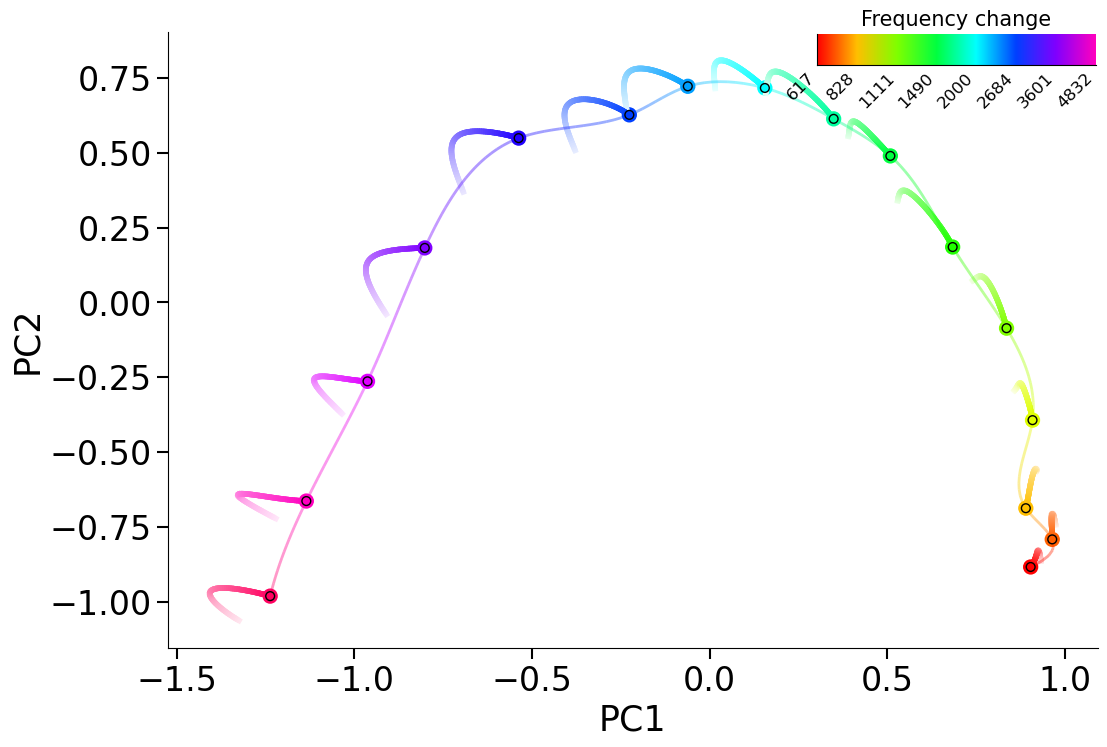

In [64]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

for i in range(len(traj_PC)) :
    draw_traj(traj_PC[i],ax,cmaps[i])

colors = get_hsv_colors()

ax.scatter(traj_PC[:,-1,0],traj_PC[:,-1,1],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_PC[:,-1,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.savefig('Plots/SVG/tonotopy_traj_-.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_-.PNG', dpi = 300,bbox_inches='tight')

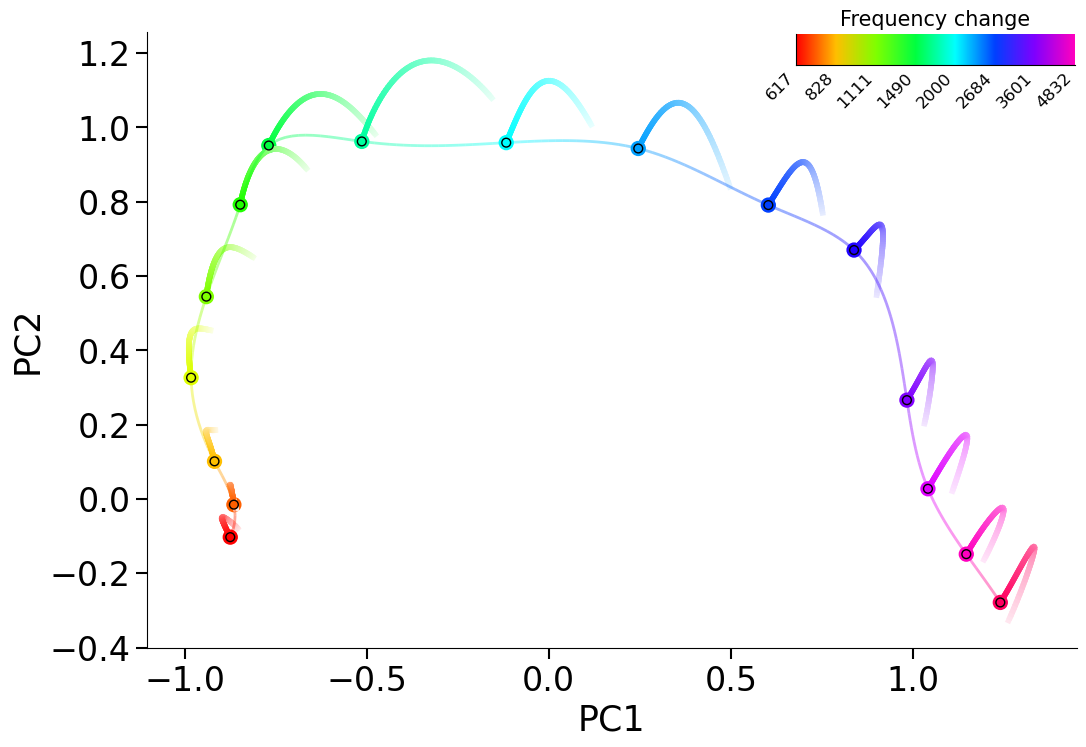

In [42]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_track_m

for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][:,:2],ax,cmaps[i])

colors = get_hsv_colors()

ax.scatter(traj_toplot[:,-1,0],traj_toplot[:,-1,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_toplot[:,-1,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.savefig('Plots/SVG/tonotopy_traj_tracking_-_hstage1.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/tonotopy_traj_tracking_-_hstage1.PNG', dpi = 300,bbox_inches='tight')

In [45]:
traj_PC_track_p.shape
traj_PC_track_m.shape

(16, 61, 10)

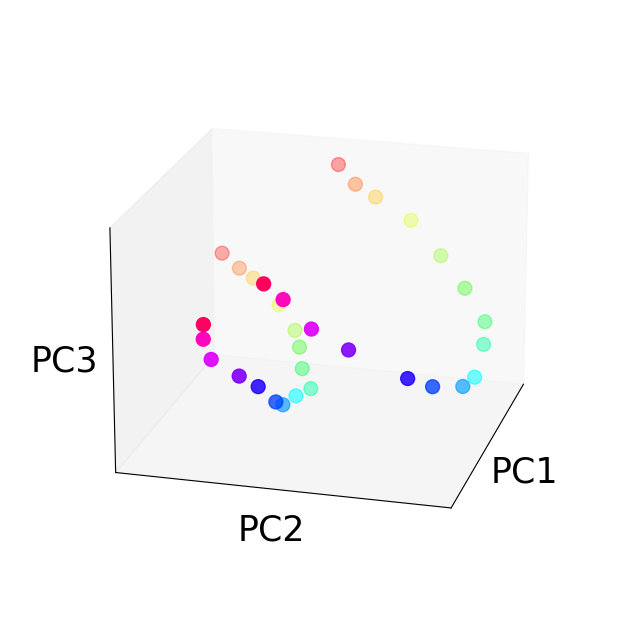

In [60]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()

traj_PC_track = (traj_PC_track_p + traj_PC_track_m)/2
traj_PC_pb = (traj_PC_pb_p + traj_PC_pb_m)/2

ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,-1,1],traj_PC_track[:,-1,2],c=colors,s=100)
ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=15, elev=20)
plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

#### Animations

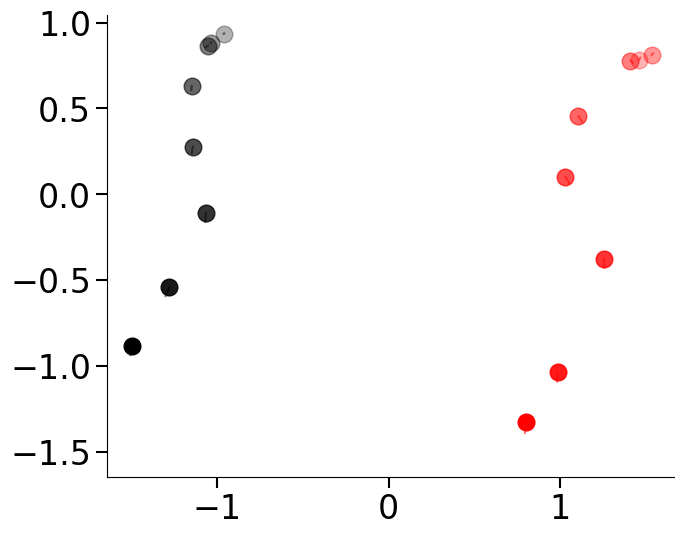

In [106]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_trajectories(trajectories, colors, interval=50, trail_length=10):
    """
    Create an animation of synchronized trajectories.

    Parameters:
        trajectories (list of np.ndarray): List of arrays of shape [T, D] (2D or 3D).
        colors (list of RGB tuples): Colors for each trajectory (same length as trajectories).
        interval (int): Milliseconds between frames.
        trail_length (int): Number of trailing points to show.

    Returns:
        anim: matplotlib.animation.FuncAnimation object.
    """
    T = min([traj.shape[0] for traj in trajectories])
    D = trajectories[0].shape[1]
    assert D in (2, 3), "Only 2D or 3D trajectories are supported."
    assert len(colors) == len(trajectories), "Colors and trajectories must match."

    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_aspect('equal')

    # Auto-scale based on all data
    all_data = np.vstack(trajectories)
    ax.set_xlim(all_data[:, 0].min() -.1, all_data[:, 0].max()+.1)
    ax.set_ylim(all_data[:, 1].min() - .1, all_data[:, 1].max() + .1)

    dots = [ax.plot([], [], 'o', color=c, markersize=12)[0] for c in colors]
    trails = [ax.plot([], [], '-', color=c, alpha=0.5)[0] for c in colors]

    def init():
        for dot, trail in zip(dots, trails):
            dot.set_data([], [])
            trail.set_data([], [])
        return dots + trails

    def update(frame):
        for i, traj in enumerate(trajectories):
            dot = dots[i]
            trail = trails[i]
            x, y = traj[frame, :2]

            dot.set_data([x], [y])

            start = max(0, frame - trail_length)
            trail.set_data(traj[start:frame+1, 0], traj[start:frame+1, 1])

        return dots + trails

    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=T, interval=interval, blit=True
    )
    return anim

ani = animate_trajectories(np.concatenate((traj_PC_track[::2],traj_PC_pb[::2]),axis=0),\
                           [(1,0,0,0.3+0.1*i) for i in range(8)]+[(0,0,0,0.3+0.1*i) for i in range(8)])
HTML(ani.to_jshtml())

### Analysis PMC

In [14]:
os.chdir('/Volumes/LaCie')

files_hercule_pmc =['HERCULE_20250528_SESSION_01/headstage_1/','HERCULE_20250602_SESSION_00/headstage_1/',\
       'HERCULE_20250603_SESSION_01/headstage_1/','HERCULE_20250604_SESSION_00/headstage_1/',\
      'HERCULE_20250604_SESSION_01/headstage_1/','HERCULE_20250605_SESSION_00/headstage_1/',\
      'HERCULE_20250605_SESSION_01/headstage_1/','HERCULE_20250606_SESSION_00/headstage_1/',\
      'HERCULE_20250612_SESSION_00/headstage_1/',\
      'HERCULE_20250612_SESSION_02/headstage_1/','HERCULE_20250616_SESSION_01/headstage_1/']

for i in range(len(files_hercule_pmc)) :
    files_hercule_pmc[i]='HERCULE/' + files_hercule_pmc[i]

files_pmc = files_hercule_pmc

n_data_pmc_s = []
f_data_pmc_s = []
for file in tqdm(files_pmc) :
    n_data = np.load(file+'data_0.005.npy')
    f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
    
    
    f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}

    for item in f_data:
        for key, value in item.items():
            f_data_dict[key].append(value)

    f_data = pd.DataFrame(f_data_dict)
    f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())

    n_data=n_data.astype(float)

    n_data_pmc_s.append(n_data)
    f_data_pmc_s.append(f_data)
    

os.chdir('/Users/hugot/Documents/PHD/Felicie')

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
c=0
for data in n_data_pmc_s :
    c+= np.shape(data)[0]
print(c)

352


In [15]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_pmc_s))) :
    n_data_smooth = gaussian_filter(n_data_pmc_s[i],sigma=20,axes=1)
    n_data_pmc_s[i] = n_data_smooth

  0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
with open("Save/hercule_pmc", "wb") as fp:   #Pickling
    pickle.dump(n_data_pmc_s, fp)

In [28]:
with open("Save/hercule_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/hercule_features", "rb") as fp:
     f_data_s = pickle.load(fp)


with open("Save/hercule_pmc", "rb") as fp:
     n_data_pmc_s = pickle.load(fp)

### Trajectories

In [29]:
all_traj_pmc = []
for i in range(len(n_data_pmc_s)) :
    n_data = n_data_pmc_s[i]
    f_data = f_data_pmc_s[i]

    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    event_idx = get_event_vicinity(triggers, w_size)
    event_freq = freq[event_idx[:,w_size-1]]

    m_traj = compute_mean_trajectories(n_data.T,event_idx,event_freq)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_pmc.append(filtered_m_traj)

    print('Events:')
    print(np.unique(event_freq,return_counts=True)[1])

Events:
[  6  42  98  89 111 108 125 139 132 127 117 113  94  83  90 142 143 160
 459 363 194  86  56   7]
Events:
[ 11  45 112 130 135 145 144 158 212 170 141 135 147 145 175 294 253 195
 243 164  70  44  22   6]
Events:
[  1   5  52 129 147 125 116 131 146 147 128  91  91  89  92 101 135 142
 179 191 145 101  77  23   9]
Events:
[  2  12  78 154  89  69 102  70  92  94 103 116 103  96 109 123 141 121
 174 196 154  90  45  14   3]
Events:
[  1   6  20  63 123 131 126  87  80  63  59  63  73  70  65  74  91  86
 120 195 233 219  92  34   1]
Events:
[  2   2  38 140 135 135  92  85  75  71  80  61  78 112 127  70 118 159
 238 155 111  95  39  16   2]
Events:
[ 11  47 147 120  55 124 139  68  66  54  60  61 107  96  93 119 170 201
 138  87  68  25  12   6]
Events:
[ 17  75 149 167 142 109 117 113 113  93 107 104 107 117 119 130 161 216
 231 158 110  65  21   1]
Events:
[  4   9  52 117 124 156 122 175 125 181 164 130 168 182 209 169 167 155
 168 187 145  78  46  14   1   1]
Events:
[  3 

In [30]:
all_traj_track_pmc = []
all_traj_pb_pmc = []
all_traj_pb_mock_pmc = []
for i in range(len(n_data_pmc_s)) :
    n_data = n_data_pmc_s[i]
    f_data = f_data_pmc_s[i]

    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    mock = f_data['Mock_frequency'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    triggers_mock = f_data['Mock_change'].to_numpy()
    condition = f_data['Condition'].to_numpy()
    triggers_track = triggers*(condition==0)
    triggers_pb = triggers*(condition==1)
    triggers_pb_mock = triggers_mock*(condition==1)
        
    event_idx_track = get_event_vicinity(triggers_track, w_size)
    event_idx_pb = get_event_vicinity(triggers_pb, w_size)
    event_idx_pb_mock = get_event_vicinity(triggers_pb_mock, w_size)
    
    event_freq_track = freq[event_idx_track[:,w_size-1]]
    event_freq_pb = freq[event_idx_pb[:,w_size-1]]
    event_mock_pb = mock[event_idx_pb_mock[:,w_size-1]]

    m_traj = compute_mean_trajectories(n_data.T,event_idx_track,event_freq_track)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_track_pmc.append(filtered_m_traj)

    m_traj = compute_mean_trajectories(n_data.T,event_idx_pb,event_freq_pb)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_pb_pmc.append(filtered_m_traj)

    m_traj = compute_mean_trajectories(n_data.T,event_idx_pb_mock,event_mock_pb)
    filtered_m_traj = {k: v for k, v in m_traj.items() if 600 <= k <= 6000}
    all_traj_pb_mock_pmc.append(filtered_m_traj)

    print('Tracking events:')
    print(np.unique(event_freq_track,return_counts=True)[1])

    print('Playback events:')
    print(np.unique(event_freq_pb,return_counts=True)[1])

    print('Mock events:')
    print(np.unique(event_mock_pb,return_counts=True)[1])

Tracking events:
[  3  19  55  46  57  57  57  76  69  68  54  63  44  38  52  70  71  72
 228 170 102  46  36   5]
Playback events:
[  3  23  43  43  54  51  68  63  63  59  63  50  50  45  38  72  72  88
 231 193  92  40  20   2]
Mock events:
[  9  32  62  65  61  70  82  65  63  72  61  70  61  55  70 102  85 105
 121  81  40  13   4   1]
Tracking events:
[  5  30  64  78  75  84  79  89 109 104  70  78  75  79 104 163 120 129
 153  98  34  20  12   2]
Playback events:
[  6  15  48  52  60  61  65  69 103  66  72  57  71  66  71 131 133  66
  90  67  35  25  10   4]
Mock events:
[ 2  6 24 38 79 53 55 74 94 48 49 55 55 55 57 48 45 67 73 75 48 33 19 15
  2]
Tracking events:
[  1   5  28  64  70  72  57  64  75  77  65  45  39  35  53  48  64  64
  81 104  69  58  40  17   6]
Playback events:
[24 65 77 53 59 67 71 70 63 46 52 54 39 53 71 78 98 87 76 43 37  6  3]
Mock events:
[ 1 22 44 41 55 40 57 52 47 52 44 36 36 32 58 92 81 88 93 82 52 26 14  2]
Tracking events:
[ 2  8 38 83 41 27 52

In [31]:
traj_df_pmc = pseudo_trajectories(all_traj_pmc)

traj_df_track_pmc = pseudo_trajectories(all_traj_track_pmc)
traj_df_pb_pmc = pseudo_trajectories(all_traj_pb_pmc)
traj_df_pb_mock_pmc = pseudo_trajectories(all_traj_pb_mock_pmc)

In [39]:
from sklearn.decomposition import PCA

traj_mat = np.stack(traj_df_pmc['trajectory'])
traj_mat_flat = traj_mat.reshape(np.shape(traj_mat)[0]*np.shape(traj_mat)[1],np.shape(traj_mat)[2])

n_comp=10
pca = PCA(n_components=n_comp)
traj_PC_pmc = pca.fit_transform(traj_mat_flat)

In [58]:
from sklearn.decomposition import PCA

traj_mat_track = np.stack(traj_df_track_pmc['trajectory'])
traj_mat_pb = np.stack(traj_df_pb_pmc['trajectory'])
#traj_mat_pb_mock = np.stack(traj_df_pb_mock['trajectory'])

traj_mat_all = np.concatenate((traj_mat_track,traj_mat_pb),axis=0)
#traj_mat_all = np.concatenate((traj_mat_track,traj_mat_pb_mock),axis=0)
#traj_mat_all = np.concatenate((traj_mat_track,traj_mat_pb,traj_mat_pb_mock),axis=0)
traj_mat_flat = traj_mat_all.reshape(np.shape(traj_mat_all)[0]*np.shape(traj_mat_all)[1],np.shape(traj_mat_all)[2])

traj_mat_track_flat = traj_mat_track.reshape(np.shape(traj_mat_track)[0]*np.shape(traj_mat_track)[1],np.shape(traj_mat_track)[2])
traj_mat_pb_flat = traj_mat_pb.reshape(np.shape(traj_mat_pb)[0]*np.shape(traj_mat_pb)[1],np.shape(traj_mat_pb)[2])

n_comp=10
pca_all = PCA(n_components=n_comp)

traj_PC_all_pmc = pca_all.fit_transform(traj_mat_flat)

#### Reproducing A1 plots

Text(0, 0.5, 'PC2')

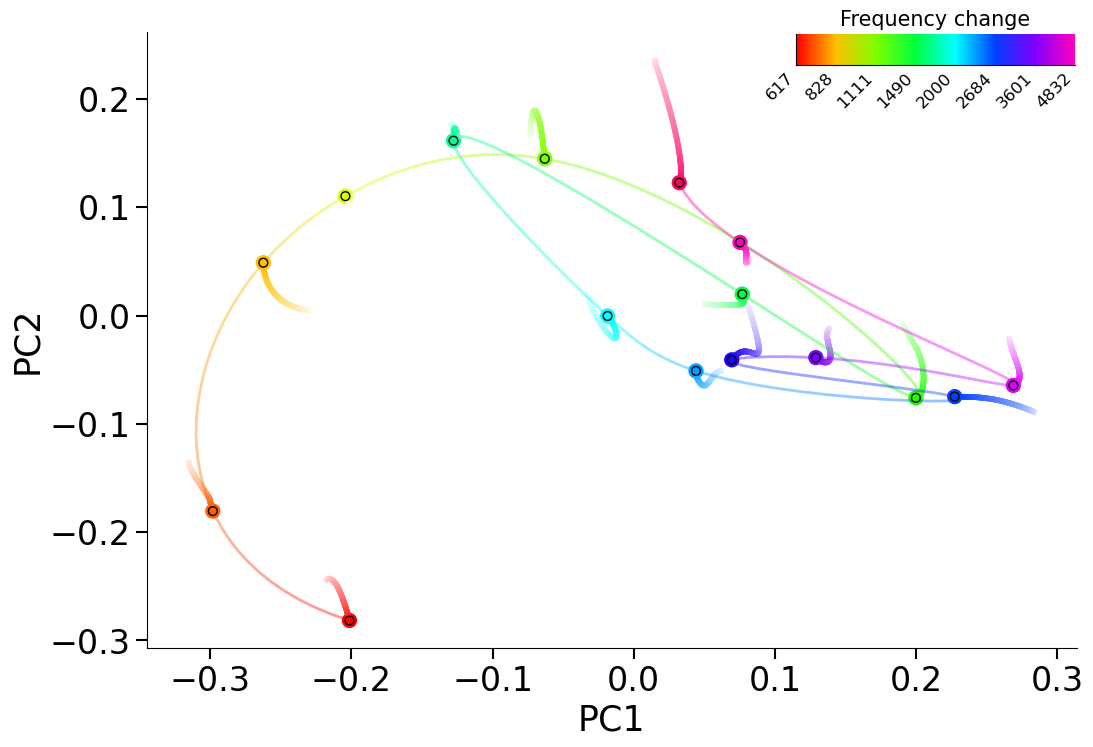

In [26]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

for i in range(len(traj_PC_pmc)) :
    draw_traj(traj_PC_pmc[i],ax,cmaps[i])

colors = get_hsv_colors()

ax.scatter(traj_PC_pmc[:,-1,0],traj_PC_pmc[:,-1,1],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_pmc['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_PC_pmc[:,-1,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.savefig('Plots/SVG/tonotopy_traj_-.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_-.PNG', dpi = 300,bbox_inches='tight')

Text(0, 0.5, 'PC2')

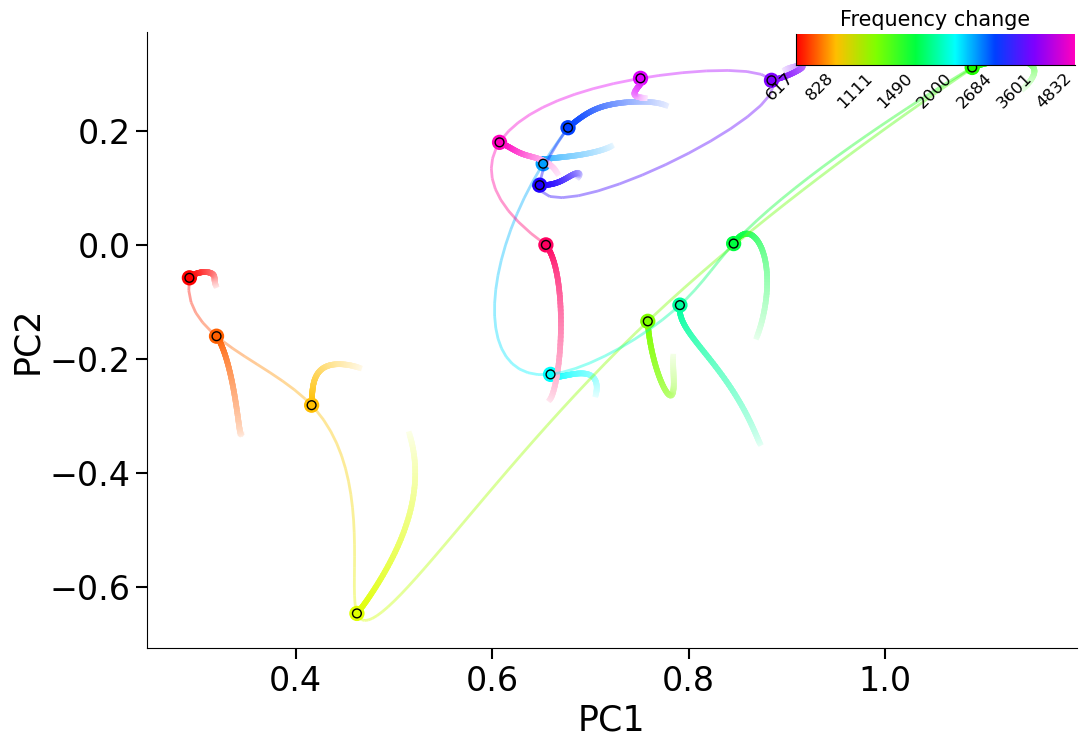

In [27]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

for i in range(len(traj_PC_track_pmc)) :
    draw_traj(traj_PC_track_pmc[i],ax,cmaps[i])

colors = get_hsv_colors()

ax.scatter(traj_PC_track_pmc[:,-1,0],traj_PC_track_pmc[:,-1,1],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_pmc['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_PC_track_pmc[:,-1,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.savefig('Plots/SVG/tonotopy_traj_-.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_-.PNG', dpi = 300,bbox_inches='tight')

Text(0, 0.5, 'PC2')

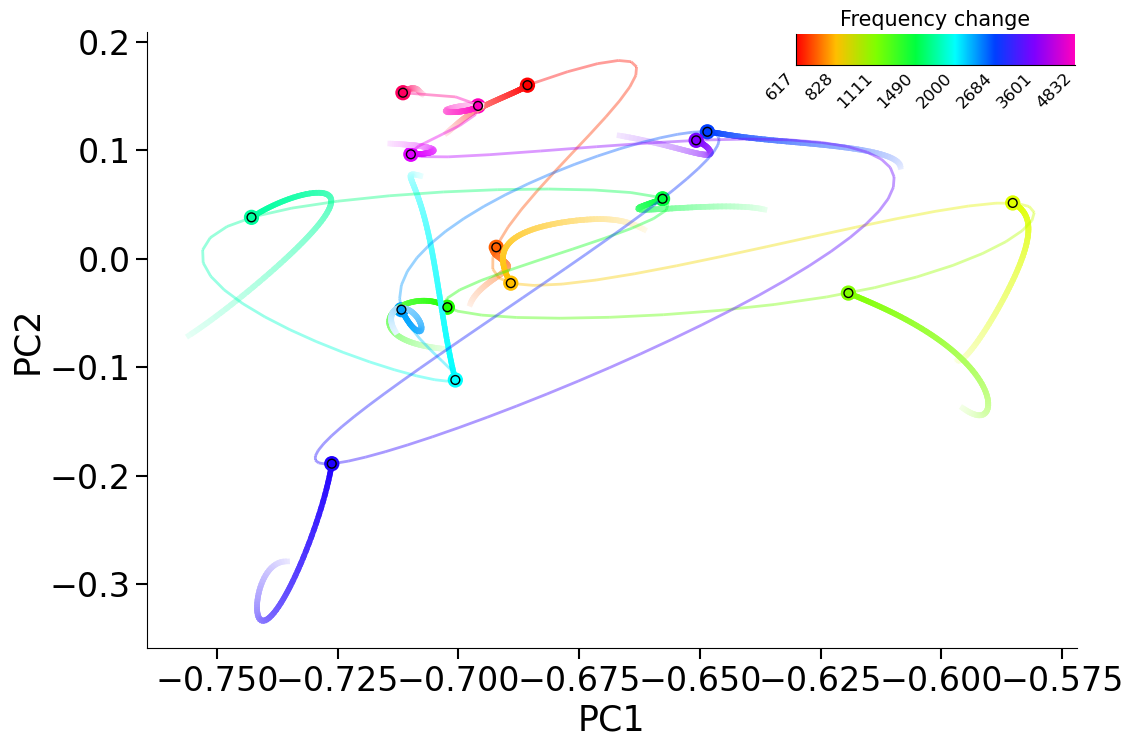

In [28]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

for i in range(len(traj_PC_pb_pmc)) :
    draw_traj(traj_PC_pb_pmc[i],ax,cmaps[i])

colors = get_hsv_colors()

ax.scatter(traj_PC_pb_pmc[:,-1,0],traj_PC_pb_pmc[:,-1,1],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_pb_pmc['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_PC_pb_pmc[:,-1,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.savefig('Plots/SVG/tonotopy_traj_-.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_-.PNG', dpi = 300,bbox_inches='tight')

### Cross-correlation

In [66]:
n_data_pmc_s[0]

def extract_cuts(index_list, data_array, min_length=1000):
    """
    Extracts cuts from a 2D array based on regions where values in the index_list
    are consistently 0 or 1 for more than min_length points.

    Parameters:
    - index_list: List[int] with values -1, 0, 1.
    - data_array: np.ndarray, 2D array with shape (N, M), M == len(index_list).
    - min_length: int, minimum length for a segment to be considered a valid cut.

    Returns:
    - cuts_0: List of np.ndarrays where index == 0 for > min_length.
    - cuts_1: List of np.ndarrays where index == 1 for > min_length.
    """
    index_array = np.array(index_list)
    assert data_array.shape[1] == len(index_list), "Data column count must match index list length."

    cuts_0 = []
    cuts_1 = []

    current_val = None
    start_idx = 0

    for i, val in enumerate(index_array):
        if val != current_val:
            if current_val in (0, 1):
                segment_length = i - start_idx
                if segment_length > min_length:
                    segment = data_array[:, start_idx:i]
                    if current_val == 0:
                        cuts_0.append(segment)
                    elif current_val == 1:
                        cuts_1.append(segment)
            start_idx = i
            current_val = val

    # Handle last segment
    if current_val in (0, 1):
        segment_length = len(index_array) - start_idx
        if segment_length > min_length:
            segment = data_array[:, start_idx:]
            if current_val == 0:
                cuts_0.append(segment)
            elif current_val == 1:
                cuts_1.append(segment)

    return [cuts_0, cuts_1]

cond_slice_a1 = [extract_cuts(f_data_s[i]['Condition'].to_numpy(),n_data_a1_s[i]) for i in range(len(f_data_s))]
cond_slice_pmc = [extract_cuts(f_data_pmc_s[i]['Condition'].to_numpy(),n_data_pmc_s[i]) for i in range(len(f_data_s))]

In [72]:
f_data_pmc_s[i][1000:1100]

,Played_frequency,Condition,Block,Frequency_changes,Mock_frequency,Mock_change,Change_direction
1000,533.0,-1.0,0.0,False,0.0,False,0
1001,533.0,-1.0,0.0,False,0.0,False,0
1002,533.0,-1.0,0.0,False,0.0,False,0
1003,533.0,-1.0,0.0,False,0.0,False,0
1004,533.0,-1.0,0.0,False,0.0,False,0
...,...,...,...,...,...,...,...
1095,533.0,-1.0,0.0,False,0.0,False,0
1096,533.0,-1.0,0.0,False,0.0,False,0
1097,533.0,-1.0,0.0,False,0.0,False,0
1098,533.0,-1.0,0.0,False,0.0,False,0


In [73]:
f_data_s[i][1000:1100]

,Played_frequency,Condition,Block,Frequency_changes,Mock_frequency,Mock_change,Change_direction
1000,0.0,0.0,0.0,False,0.0,False,0
1001,0.0,0.0,0.0,False,0.0,False,0
1002,0.0,0.0,0.0,False,0.0,False,0
1003,0.0,0.0,0.0,False,0.0,False,0
1004,0.0,0.0,0.0,False,0.0,False,0
...,...,...,...,...,...,...,...
1095,0.0,0.0,0.0,False,0.0,False,0
1096,0.0,0.0,0.0,False,0.0,False,0
1097,0.0,0.0,0.0,False,0.0,False,0
1098,0.0,0.0,0.0,False,0.0,False,0


Text(0.5, 0, 'Time')

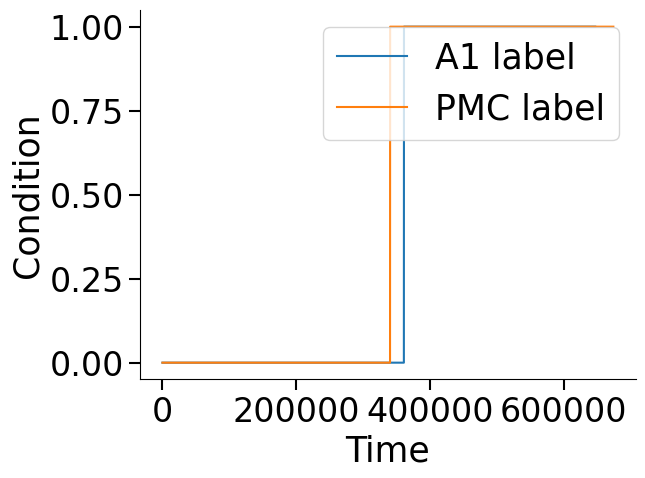

In [108]:
plt.plot(f_data_s[0]['Condition'],label='A1 label')
plt.plot(f_data_pmc_s[0]['Condition'],label='PMC label')

plt.legend()
plt.ylabel('Condition')
plt.xlabel('Time')

In [67]:
for i in range(len(n_data_pmc_s)) :
    print(np.shape(cond_slice_a1[i][0][0]))
    print(np.shape(cond_slice_pmc[i][0][0]))

(26, 361042)
(32, 340347)
(21, 360711)
(32, 339356)
(20, 360663)
(32, 303149)
(21, 361378)
(32, 301846)
(22, 360751)
(32, 252006)
(25, 360876)
(32, 302394)
(27, 360707)
(32, 245630)
(14, 59995)
(32, 315180)
(17, 59952)
(32, 60002)
(22, 59385)
(32, 60078)
(24, 12772)
(32, 60322)


In [39]:
import numpy as np

def pairwise_correlations(array1, array2):
    """
    Compute all pairwise Pearson correlations between neurons in two 2D arrays.

    Parameters:
    - array1: np.ndarray of shape (N1, T) where N1 is number of neurons, T is number of time points
    - array2: np.ndarray of shape (N2, T)

    Returns:
    - correlation_matrix: np.ndarray of shape (N1, N2) with correlation coefficients
    """
    assert array1.shape[1] == array2.shape[1], "Arrays must have the same number of time points (columns)"

    # Normalize both arrays (zero mean, unit variance)
    a1 = (array1 - array1.mean(axis=1, keepdims=True)) / array1.std(axis=1, keepdims=True)
    a2 = (array2 - array2.mean(axis=1, keepdims=True)) / array2.std(axis=1, keepdims=True)

    # Compute correlation matrix using matrix multiplication
    correlation_matrix = np.dot(a1, a2.T) / array1.shape[1]

    return correlation_matrix



array([0., 0., 0., ..., 1., 1., 1.])

### CCA

In [ ]:
np.save('Save/A1_PC',traj_PC_all_flat)
np.save('Save/PMC_PC',traj_PC_all_pmc)

In [84]:
A = np.load('Save/A1_PC.npy')
P = np.load('Save/PMC_PC.npy')

In [85]:
cca = CCA(n_components=3)

cca.fit(A,P)

def compute_CCA_scores(X,Y,cca) :
    scores = []
    for i in range(cca.n_components) :
        x_i = X@cca.x_weights_[:,i]
        y_i = Y@cca.y_weights_[:,i]
        
        scores.append(pearsonr(x_i,y_i)[0])
        
    return np.array(scores)

compute_CCA_scores(A,P,cca)

array([0.98593854, 0.87998052, 0.75976434])

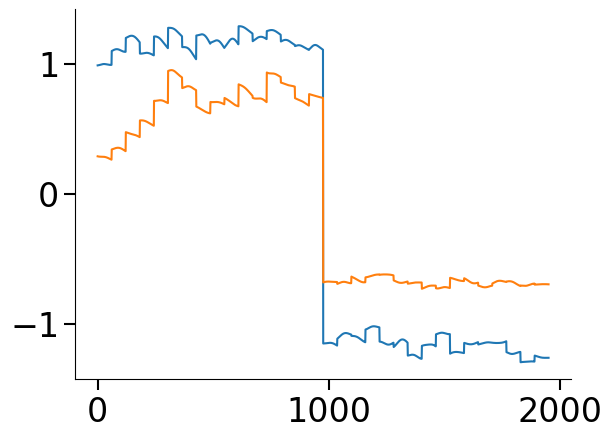

In [86]:
plt.plot(A@cca.x_weights_[:,0])
plt.plot(P@cca.y_weights_[:,0])